In [1]:
%matplotlib inline
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ipywidgets as widgets
import datetime
import seaborn as sns
import scipy
import statsmodels.api as sm
from ipywidgets import interact, interact_manual
import dateutil.parser
from tqdm.notebook import tqdm


In [2]:
dir_data = '../data/reservoir-time-series-2022-Q2'

# input
dir_eo = f'{dir_data}/time_series_area_raw/'

# output
dir_eo_monthly = f'{dir_data}/time_series_area_monthly/' 
dir_eo_small = f'{dir_data}/time_series_area/' # raw time,area series only


In [3]:
pathlib.Path(dir_eo_monthly).mkdir(exist_ok=True)
pathlib.Path(dir_eo_small).mkdir(exist_ok=True)

In [3]:
reservoirs_by_filenames = list(pathlib.Path(dir_eo).glob('*.csv'))

In [5]:
# specific file only
# reservoirs_by_filenames = list(pathlib.Path(dir_eo).glob('0090567.csv'))

In [4]:
def get_data(filename):
    df = pd.read_csv(pathlib.Path(dir_eo) / filename)

    df = df.rename(columns = { 
        'water_area_time': 'time'
    })
    
    df['time_ms'] = df.time

    df.time = pd.to_datetime(df.time, unit='ms', utc=True)
    df = df.set_index('time')

    df = df[df.water_area_filled_fraction < 0.3]
    df = df[df.quality_score < 0.3]
    

    return df


In [5]:
# remove large gradients
def remove_large_gradients(df, th):
    df['water_area_filled_grad'] = df.area.diff()
    df = df[pd.notnull(df.water_area_filled_grad)]

    if len(df.water_area_filled_grad.to_numpy()):
        grad_th = np.percentile(np.abs(df.water_area_filled_grad.to_numpy()), th)
        df = df[np.abs(df.water_area_filled_grad) < grad_th]

    return df


In [23]:
def clean_data(df_eo, step='MS', skip_missings=True, min_missings_step=12):
    d = df_eo
    d['area'] = d.water_area_filled
    # d['area'] = d.water_area_value
    
    d = d[['area']]

    # round to days
    d.index = d.index.round('D')

    # d = remove_large_gradients(d, 85)
    # d = remove_large_gradients(d, 85)

    # d = remove_large_gradients(d, 95)
    d = remove_large_gradients(d, 99)

    # take top 90% (eliminate underfilling due to lower trust in water occurrence)
    
    d = d.rolling(3, min_periods=3, center=True).apply(lambda x: x.quantile(0.5))
    d = d.resample(step).apply(lambda x: x.mean())
     

    # create mask
    if skip_missings:
        mask = d.copy()
        grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
        grp['ones'] = 1
        mask['area'] = (grp.groupby('area')['ones'].transform('count') < min_missings_step) | d['area'].notnull()

    # smoothen
    d = d.interpolate(method='pchip')
    # d = d.interpolate(method='akima')
    # d = d.shift(-1)

    # apply missing values mask (>6 months)
    if skip_missings:
        d[mask.area == False] = None


    # smoothen using akima
    # df_eo = df_eo.interpolate(method='akima')
#     df_eo = df_eo.interpolate(method='barycentric')
    # df_eo = df_eo.shift(-1)


#     df2 = df2.sort_index()
#     z = sm.nonparametric.lowess(df2.water_area_filled, df2.time_ms, return_sorted=False, frac=1/200)
#     df2['z'] = z
#     ax.plot(df2.index, df2.z, 'g-')

#     df3 = df2.resample('W').max().interpolate(method='polynomial', order=2)
#     df3 = df3.ewm(span = 3).mean()


#     df3 = df3.resample('3W').mean()

#     df3 = df3.shift(-1)
#     df3 = df2.resample('W').max().interpolate(method='linear')
#     df2 = df2.resample('D').interpolate(method='polynomial', order=2)
#     df2 = df2.resample('D').interpolate(method='akima')

#     df4 = df3.sort_index()
#     z = sm.nonparametric.lowess(df4.water_area_filled, df4.time_ms, return_sorted=False, frac=1/100)
#     df4['z'] = z
#     ax.plot(df4.index, df4.z, 'b-')

#     ax.plot(df2.index, df2.water_area_filled, 'b-')

    return d


In [12]:
def plot(filename, show_quality_metrics=False, title=None, show_unfilled=False, show_monthly=True):
    df = get_data(filename)

#     date_start = '2000-01-01'
#     date_stop = '2018-08-01'
#     df = df[df.index > dateutil.parser.parse(date_start)]

    fig, ax = plt.subplots(figsize=(20, 7))
    
#     ax.plot(df.index, df.water_area_value, 'r.', alpha=0.3)
#     ax.plot(df.index, df.water_area_filled, 'g.')
#     ax.set_xlim([dateutil.parser.parse(date_start), dateutil.parser.parse(date_stop)])    
    
    df_clean = clean_data(df)

    # TODO: compute outliers

    # plot original points
    # quality_score_th = np.quantile(df.quality_score, 0.85)
    df_no_outliers = df # [df.quality_score < quality_score_th]
    
    ax.plot(df_no_outliers.index, df_no_outliers.area, 'r.', alpha=0.9, markersize=2)
    
    if show_unfilled:
        ax.plot(df_no_outliers.index, df_no_outliers.water_area_value, 'b.', alpha=0.9, markersize=2)

    # plot outliers
    # quality_score_th = np.quantile(df.quality_score, 0.9)
    # df_outliers = df[df.quality_score > quality_score_th]
    # ax.plot(df_outliers.index, df_outliers.area, 'bo', alpha = 0.2, markersize = 5)

    # plot interpolated smoothed, converted to equidistant time scale
    if show_monthly:
        ax.plot(df_clean.index, df_clean.area, 'k-')

    if title:
        ax.set_title('Surface water area of Lake Mead as seen by Landsat 4, 5, 7, 8 and Sentinel-2 missions')

#     ax.plot(df_monthly.time, df_monthly.area, 'k-')
#     ax.scatter(df_raw.time, df_raw.area, s=2, alpha=0.9, color='red')    
    plt.grid(axis='both')
    plt.show()

    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(df.index, df.quality_score,'b.', alpha=0.9, markersize=2)
    ax.set_title('quality score (brightness)')
    plt.show()

    fig, ax = plt.subplots(figsize=(20,3))
    ax.set_title('NDWI threshold')
    ax.plot(df.index, df.ndwi_threshold, 'b.', alpha=0.9, markersize=2)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('water area filled fraction')
    ax.plot(df.index, df.water_area_filled_fraction, 'b.', alpha=0.9, markersize=2)
    plt.show()


    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('JRC water occurrence probability')
    ax.plot(df.index, df.water_area_p, 'b.', alpha=0.9, markersize=2)
    plt.show()

    

    # print(df.columns)
    # 'mission', 'ndwi_threshold', 'quality_score', 'water_area_filled', 'water_area_filled_fraction', 'water_area_p', 'water_area_value', 'scale', 'area'

    return df

    


C:\opt\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


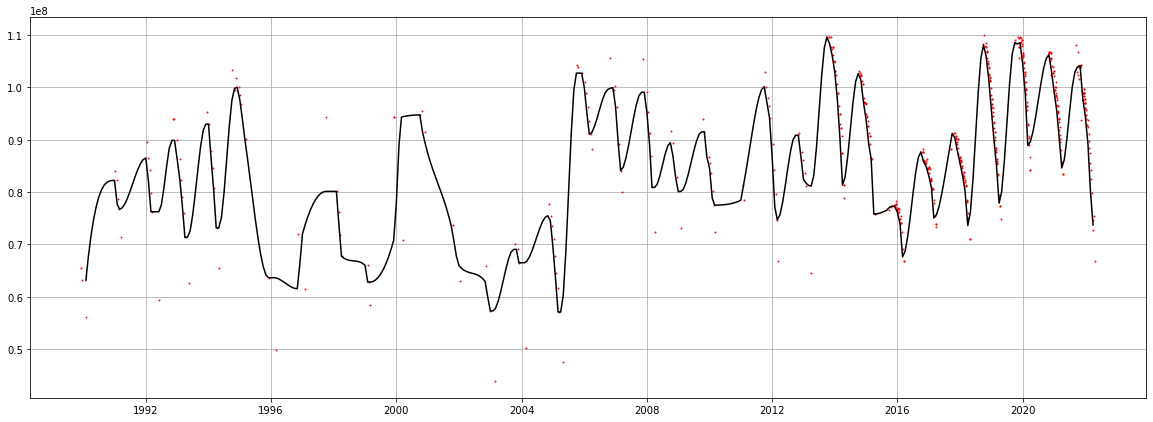

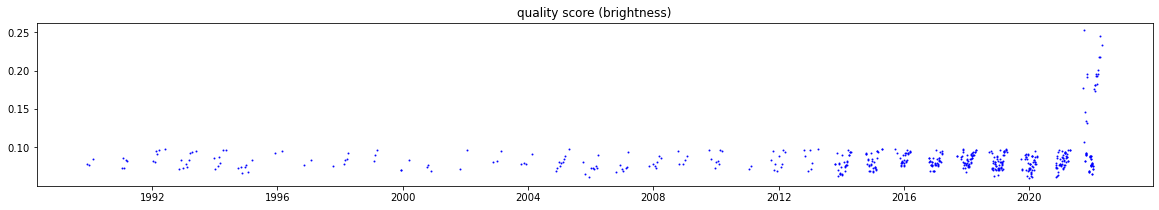

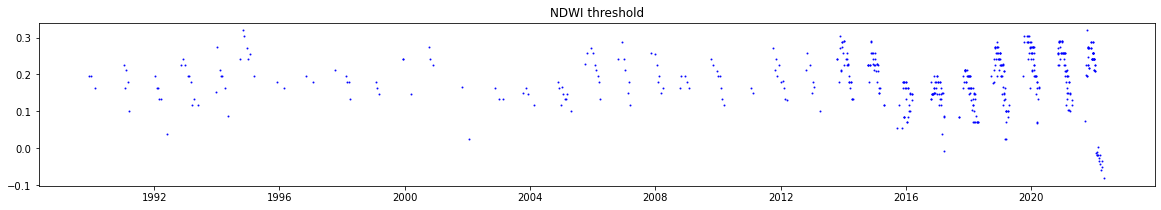

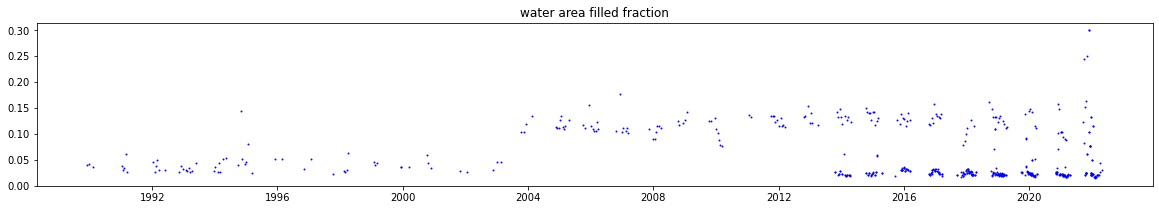

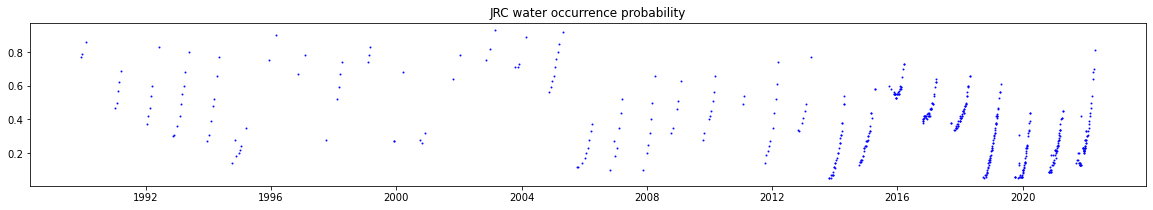

In [24]:
de = plot('0089034.csv')


C:\opt\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


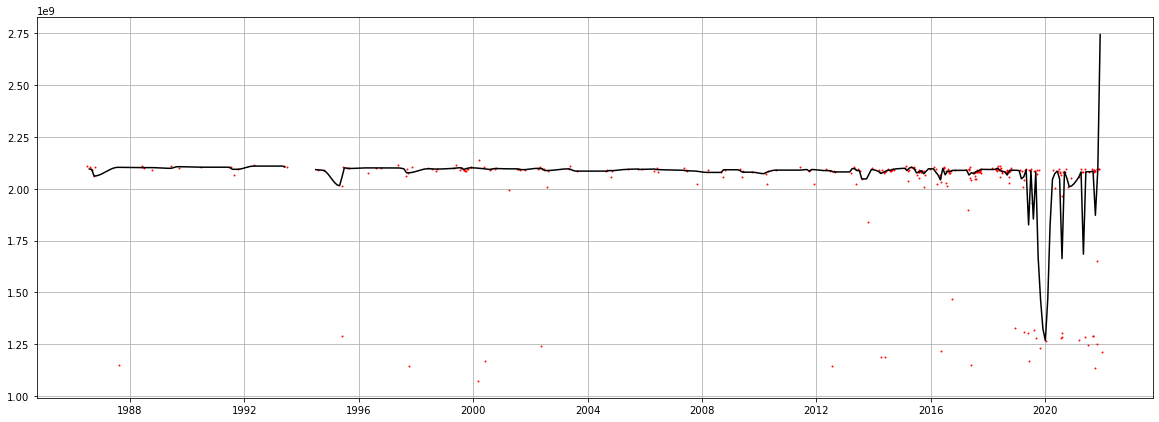

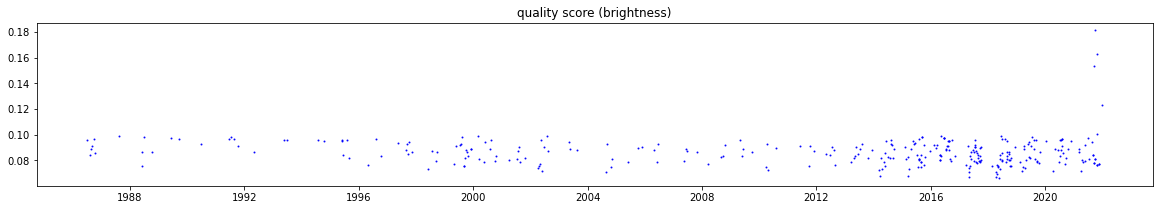

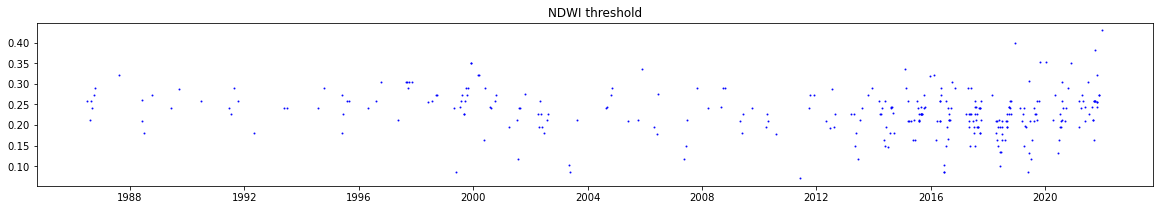

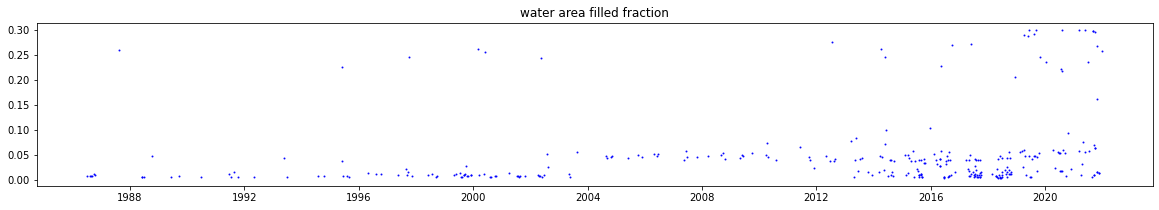

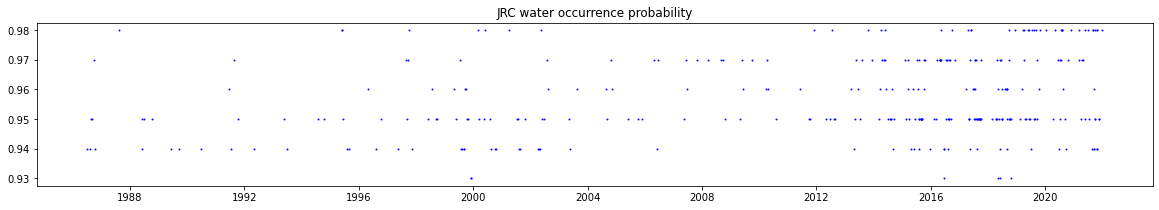

In [25]:
de = plot('0092039.csv')


C:\opt\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


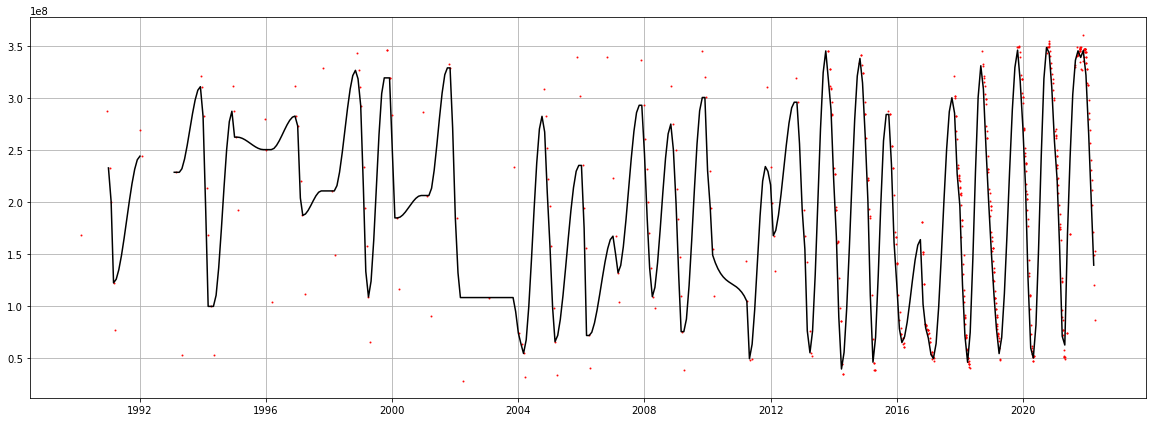

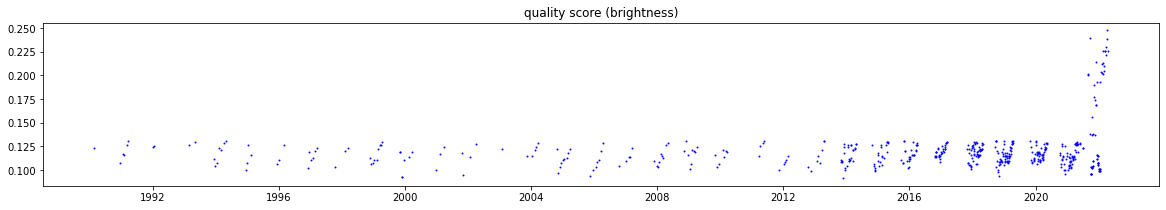

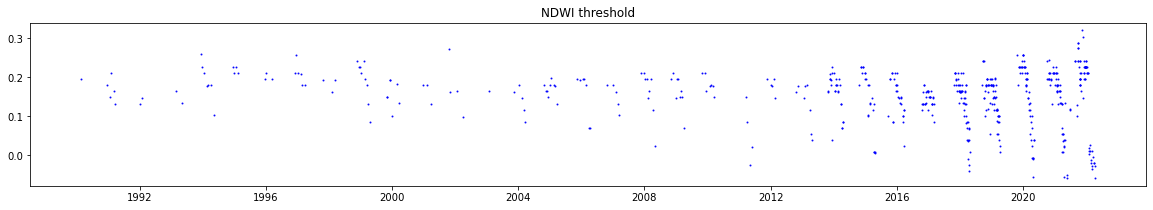

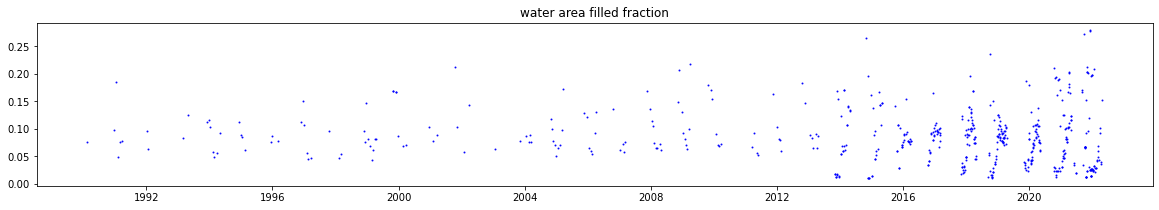

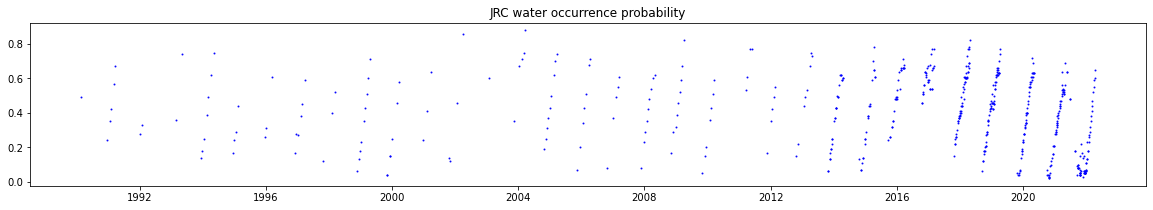

In [27]:
de = plot('0090213.csv')

C:\opt\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


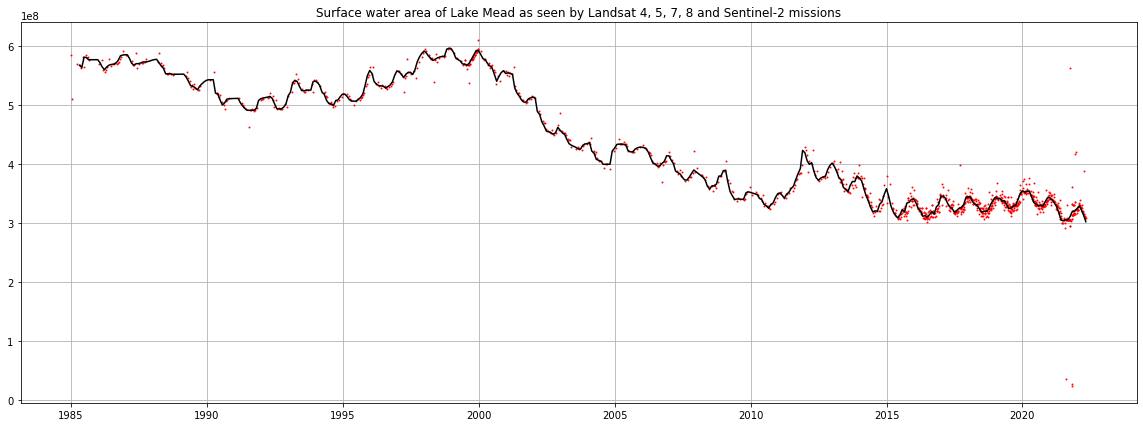

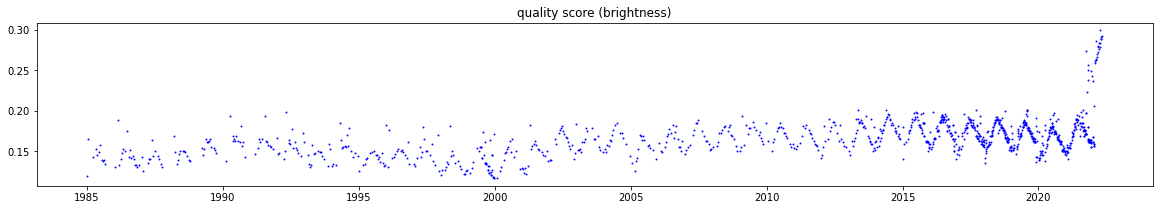

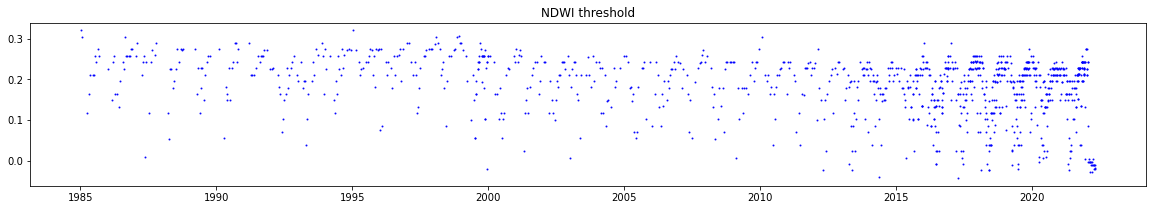

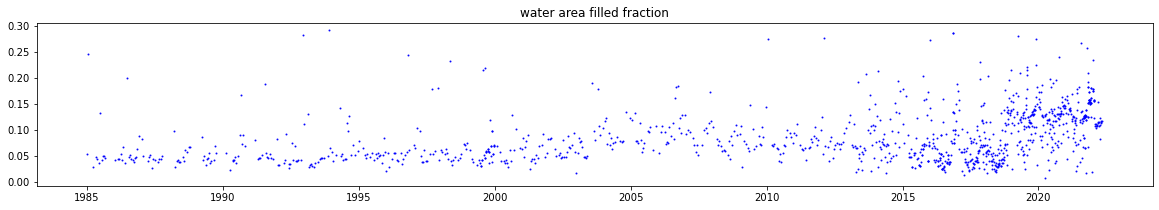

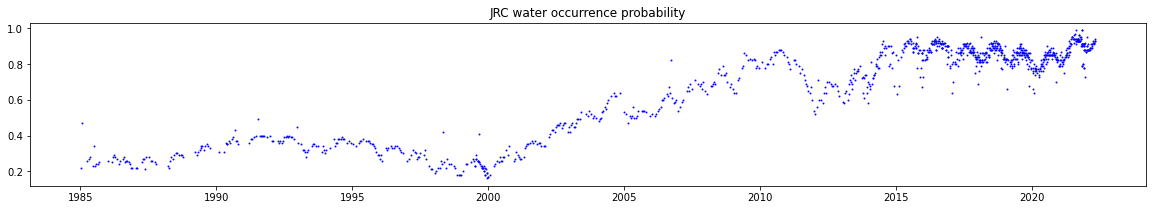

In [16]:
de = plot('0090554.csv', False,
          'Surface water area [m^2] of Lake Mead as seen by Landsat 4, 5, 7, 8 and Sentinel-2 missions')


In [446]:
df.to_csv(r'D:\src\global-water-watch\research-reservoir-water-dynamics\data\reservoir-time-series-2021-Q3\0088190.csv')


C:\opt\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


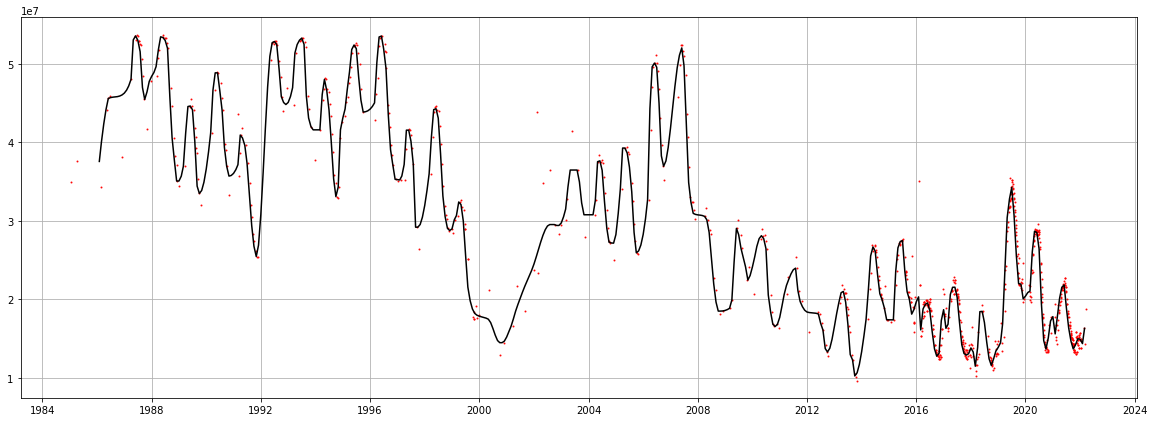

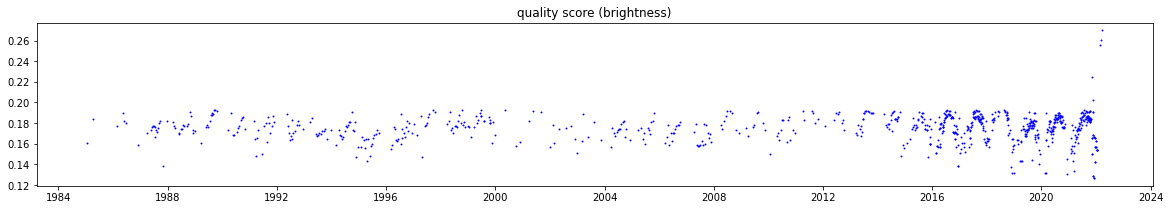

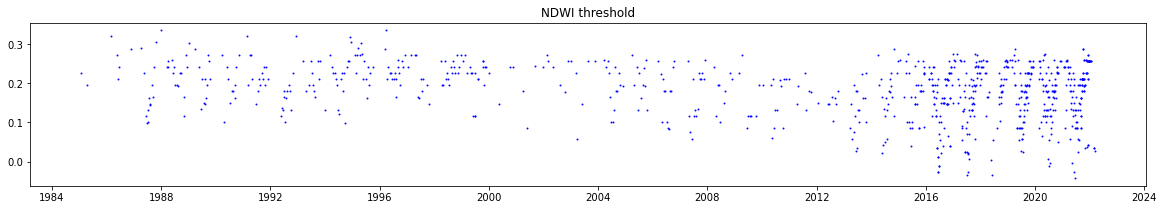

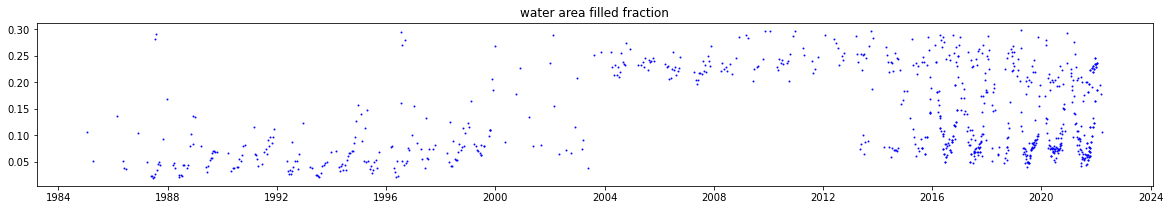

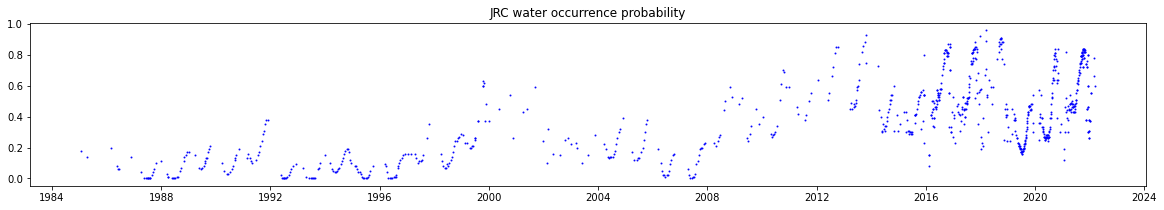

In [17]:
df = plot('0088190.csv', show_monthly=True)


In [48]:
import tqdm.notebook

In [50]:
# export all

start_index = 0

for f in tqdm.notebook.tqdm(list(reservoirs_by_filenames)[start_index:]):
    df = get_data(f)

    if(not df.size):
        print('Empty, ' + str(f) + ' skipping ...')
        pd.DataFrame({ 'time': [], 'area': []}).to_csv(dir_eo_monthly + str(f.name).split('.')[0] + '.csv')
        continue

    df = clean_data(df)
    
    df.loc[df.area < 0, 'area'] = 0
    
    df[['area']].dropna().to_csv(dir_eo_monthly + str(f.name).split('.')[0] + '.csv')

In [63]:
# export small (cleaner csv, only [time, area])

for f in tqdm.notebook.tqdm(reservoirs_by_filenames):
    df = get_data(f)
    df['area'] = df.water_area_filled
    df[['area']].to_csv(dir_eo_small + f.stem + '.csv', date_format='%Y-%m-%d %H:%M')


In [265]:
def clean_data(df_eo, step='MS', skip_missings=True, min_missings_step=12):
    d = df_eo
    d['area'] = d.water_area_filled
    d = d[['area']]

    # round to days
    d.index = d.index.round('D')

    # d = remove_large_gradients(d, 85)
    # d = remove_large_gradients(d, 85)

    d = remove_large_gradients(d, 90)
    d = remove_large_gradients(d, 98)

    # take top 90% (eliminate underfilling due to lower trust in water occurrence)
    d = d.rolling(3, min_periods=3, center=True).apply(lambda x: x.quantile(0.50))
    d = d.resample(step).apply(lambda x: x.mean())

    # create mask
    if skip_missings:
        mask = d.copy()
        grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
        grp['ones'] = 1
        mask['area'] = (grp.groupby('area')['ones'].transform(
            'count') < min_missings_step) | d['area'].notnull()

    # smoothen
    d = d.interpolate(method='pchip')
    # d = d.shift(-1)

    # apply missing values mask (>6 months)
    if skip_missings:
        d[mask.area == False] = None

    return d


In [197]:
df1 = df_clean.copy()[['area']]
df1.head(5)


,area
time,
2000-03-31,5.963115e+08
2000-04-30,5.883262e+08
2000-05-31,5.850103e+08
2000-06-30,5.776706e+08
2000-07-31,5.752003e+08


In [196]:
df2 = df.copy()[['area']]
df2.head(5)

,area
time,
2000-01-04 17:50:38.768,6.076034e+08
2000-01-13 17:44:20.551,4.870471e+08
2000-01-20 17:50:19.283,6.035854e+08
2000-01-28 18:08:22.696,6.013118e+08
2000-02-29 18:08:12.915,5.980876e+08


In [308]:
df.loc[df.index.drop_duplicates()]['area']


time
2000-01-04 17:50:38.768    6.076034e+08
2000-01-13 17:44:20.551    4.870471e+08
2000-01-20 17:50:19.283    6.035854e+08
2000-01-28 18:08:22.696    6.013118e+08
2000-02-29 18:08:12.915    5.980876e+08
                               ...     
2021-09-10 18:15:50.800    3.050372e+08
2021-09-12 18:34:06.022    3.054909e+08
2021-09-22 18:34:07.443    3.049732e+08
2021-09-26 18:15:54.176    2.958731e+08
2021-09-27 18:34:13.725    3.057962e+08
Name: area, Length: 1070, dtype: float64

In [269]:
df_clean


,area,water_area_filled_grad
time,,
1985-05-01,NaN,NaN
1985-06-01,5.806815e+08,4.724447e+06
1985-07-01,5.921462e+08,3.538097e+06
1985-08-01,5.920876e+08,-6.425491e+05
1985-09-01,5.905000e+08,-1.890215e+06
...,...,...
2021-05-01,3.206214e+08,3.432667e+05
2021-06-01,3.153584e+08,5.825819e+06
2021-07-01,3.066168e+08,1.436214e+06


In [271]:
new_index = df_clean.index.join(df.index, how = 'outer')
df_interp = df_clean.reindex(index = new_index).interpolate('linear').loc[df.index]

res = df.loc[df.index, 'area'] - df_interp['area']
#new_index

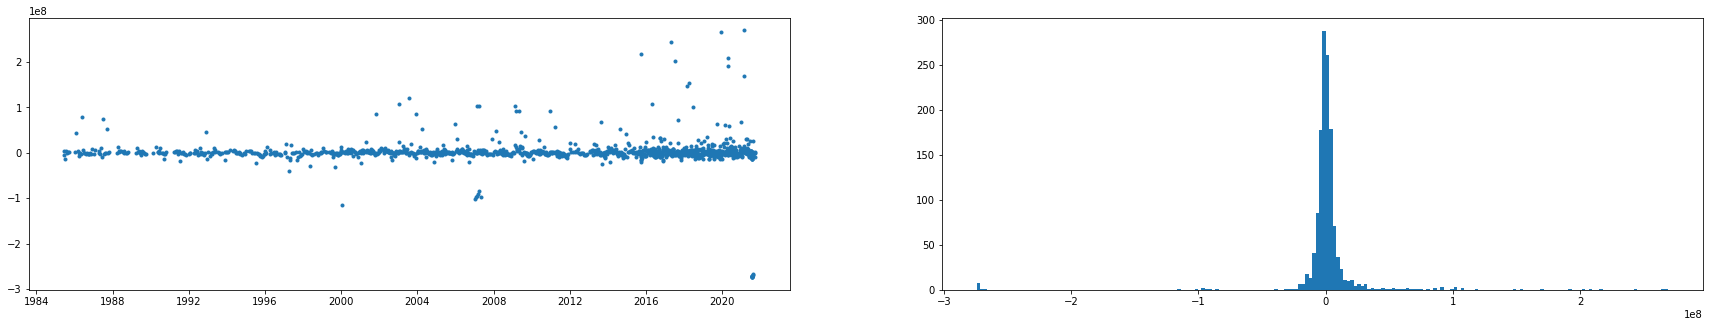

In [273]:
fix, ax = plt.subplots(1, 2, figsize=(30, 5))
ax[0].plot(res, '.')
ax[1].hist(res, 200);

In [208]:
df

,mission,ndwi_threshold,quality_score,water_area_filled,water_area_filled_fraction,water_area_p,water_area_value,scale,area,system:index,.geo,time_ms
time,,,,,,,,,,,,
2000-01-04 17:50:38.768,L5,0.288407,0.121525,6.076034e+08,0.113587,0.271919,5.385877e+08,120.514499,6.076034e+08,NaN,NaN,947008238768
2000-01-13 17:44:20.551,L5,0.226651,0.142060,4.870471e+08,0.223251,0.287168,3.783133e+08,120.514499,4.870471e+08,NaN,NaN,947785460551
2000-01-20 17:50:19.283,L5,0.195420,0.141029,6.035854e+08,0.085645,0.291066,5.518914e+08,120.514499,6.035854e+08,NaN,NaN,948390619283
2000-01-28 18:08:22.696,L7,0.243032,0.116848,6.013118e+08,0.050173,0.291111,5.711424e+08,120.514499,6.013118e+08,NaN,NaN,949082902696
2000-02-29 18:08:12.915,L7,0.148130,0.217860,5.980876e+08,0.167042,0.314171,4.981818e+08,120.514499,5.980876e+08,NaN,NaN,951847692915
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-10 18:15:50.800,L8,0.211692,0.176811,3.050372e+08,0.065423,0.940000,2.850808e+08,120.514499,3.050372e+08,1_2_LC08_039035_20210910,"{""type"":""MultiPoint"",""coordinates"":[]}",1631297750800
2021-09-12 18:34:06.022,S2,0.212278,0.174818,3.054909e+08,0.125297,0.930000,2.672138e+08,120.514499,3.054909e+08,2_20210912T181909_20210912T182942_T11SQA,"{""type"":""MultiPoint"",""coordinates"":[]}",1631471646022
2021-09-22 18:34:07.443,S2,0.227085,0.170887,3.049732e+08,0.128289,0.930000,2.658486e+08,120.514499,3.049732e+08,2_20210922T181959_20210922T182931_T11SQA,"{""type"":""MultiPoint"",""coordinates"":[]}",1632335647443


In [142]:
# export daily and monthly with ms timestamps and parquet format (smaller size)

In [64]:
# path = pathlib.Path(dir_eo_small)
# dir_eo_raw_ms = path.parent / f'{path.name}-ms'
# dir_eo_raw_ms.mkdir(exist_ok=True)

# path = pathlib.Path(dir_eo_monthly)
# dir_eo_monthly_ms = path.parent / f'{path.name}-ms'
# dir_eo_monthly_ms.mkdir(exist_ok=True)

In [65]:
# t_epoch = np.datetime64('1970-01-01T00:00:00')
# sec = np.timedelta64(1, 's')

In [68]:
# # convert raw (datetime, area) => (timestamp, area)
# for path in tqdm(reservoirs_by_filenames):
#     path_in = pathlib.Path(dir_eo_small) / f'{path.stem}.csv'
#     path_out = dir_eo_raw_ms / f'{path.stem}.parquet'

#     df = pd.read_csv(path_in)
#     df['time']= df.time.apply(lambda t: int((np.datetime64(t) - t_epoch) / sec))

#     df.to_parquet(path_out, index=False)

In [ ]:
# f = next(filter(lambda f: f.name == '0035618.csv', reservoirs_by_filenames))
# pd.DataFrame({'time': [], 'area': []}).to_csv(
#     dir_eo_monthly + str(f.name).split('.')[0] + '.csv', index=False)
# pd.DataFrame({'time': [], 'area': []}).to_parquet(
#     dir_eo_raw_ms / f'{f.stem}.parquet', index=False)
# pd.DataFrame({'time': [], 'area': []}).to_parquet(
#     dir_eo_monthly_ms / f'{f.stem}.parquet', index=False)


In [79]:
# # convert raw (datetime, area) => (timestamp, area)
# for path in tqdm(reservoirs_by_filenames):
#     path_in = pathlib.Path(dir_eo_monthly) / f'{path.stem}.csv'
#     path_out = dir_eo_monthly_ms / f'{path.stem}.parquet'

#     df = pd.read_csv(path_in)
#     df['time']= df.time.apply(lambda t: int((np.datetime64(t) - t_epoch) / sec))

#     df.to_parquet(path_out, index=False)
